# Курс "Машинное обучение в бизнесе"

## Практическое задание урока 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

## Решение

Подлючение библиотек и скриптов

In [325]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. Загрузка данных

**Описание датасета**

Возьмем датасет из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/Adult

* **age:** continuous.

* **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

* **fnlwgt:** continuous.

* **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

* **education-num:** continuous.

* **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

* **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

* **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

* **sex:** Female, Male.

* **capital-gain:** continuous.

* **capital-loss:** continuous.

* **hours-per-week:** continuous.

* **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [276]:
df = pd.read_csv("adult.data", 
                 names=['age', 'workclass', 'fnlwgt', 'education',
                        'education-num', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'capital-gain',
                        'capital-loss', 'hours-per-week', 'native-country', 'income'])
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


### 2. Обзор датасета

В датасете имеются 14 признаков и 1 целевая переменная (бинарная) - нужно определить зарабатывает человек свыше 50К в год или нет.

In [277]:
print(df.shape)

(32561, 15)


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [279]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

* В датасете содержится 32561 образцов.
* В датасете есть как категориальные, так и числовые столбцы.
* Столбцы не имеют пропущенных значений.

#### Обработка числовых столбцов

In [280]:
# выбираем числовые столбцы
num_attributes = df.select_dtypes(include=['int64'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [281]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A488D4DBC8>,
      dtype=object)

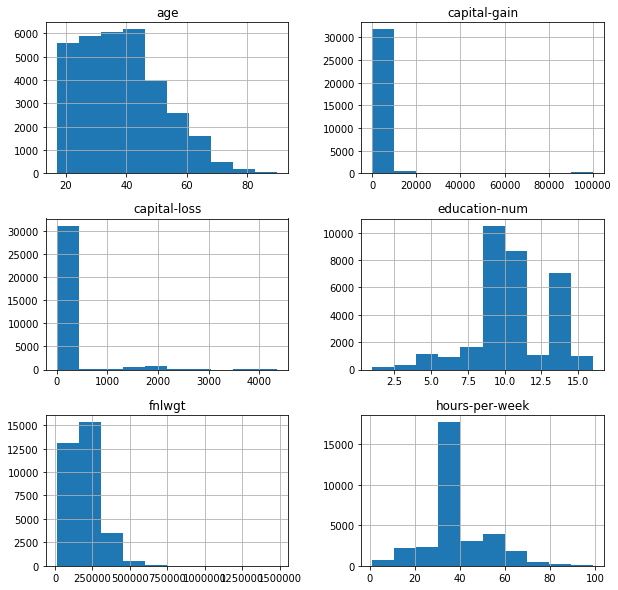

In [282]:
num_attributes.hist(figsize=(10,10))

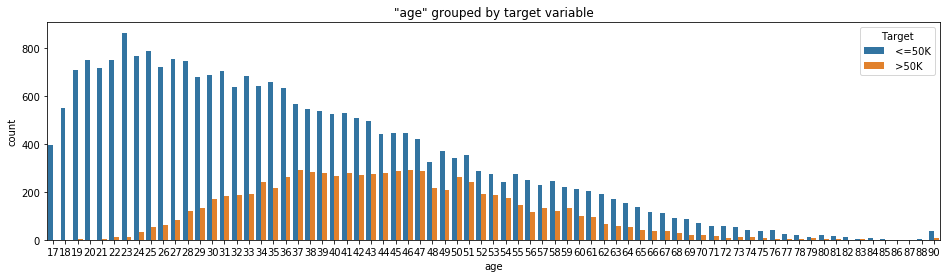

In [283]:
# столбец age и целевая переменная
plt.figure(figsize=(16, 4))

sns.countplot(x="age", hue='income', data=df)
plt.title('\"age\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### Обработка категориальных столбцов

In [284]:
cat_attributes = df.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


In [285]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


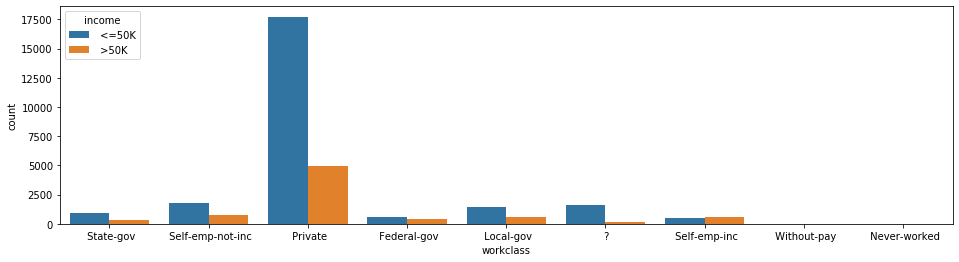

In [286]:
plt.figure(figsize=(16, 4))
sns.countplot(x='workclass', hue='income', data = cat_attributes)

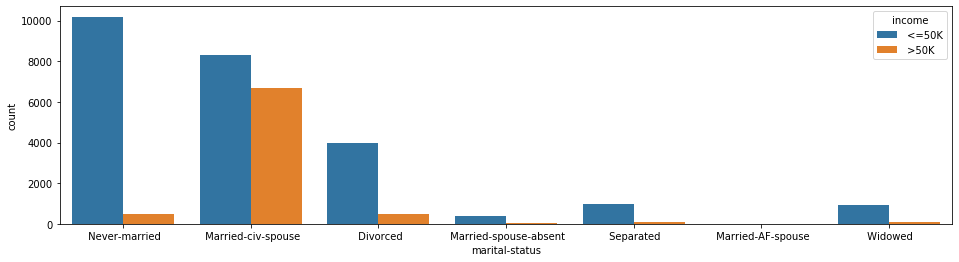

In [287]:
plt.figure(figsize=(16, 4))
sns.countplot(x='marital-status', hue='income', data = cat_attributes)

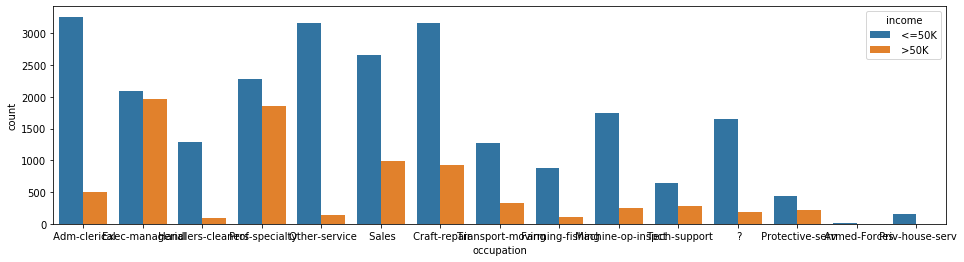

In [288]:
plt.figure(figsize=(16, 4))
sns.countplot(x='occupation', hue='income', data = cat_attributes)

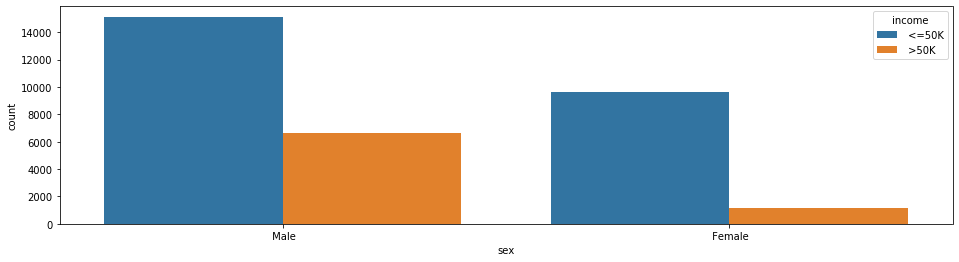

In [289]:
plt.figure(figsize=(16, 4))
sns.countplot(x='sex', hue='income', data = cat_attributes)

### 3. Feature engineering

Создадим копию набора данных

In [290]:
df_copy = df.copy()

Посмотрим на соотношение классов целевой переменной

In [291]:
df_copy['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

Приведем поле целевой переменной 'income' к бинарному виду (1 или 0): Значение ' >50K' означает 1, а все остальные - 0.

In [292]:
df_copy['income'] = df_copy['income'].map({' <=50K': 0, ' >50K': 1})
df_copy['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

Отбросим столбцы, которые не нужны:
* fnlwgt - вес выборки, столбец не связан с целевой переменной
* education - просто строковое представление столбца education-num

In [293]:
df_copy.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [294]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('income', 1), 
                                                    df_copy['income'], random_state=0)

In [295]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, type):
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=[self.type])

    
"""
Выбираем числовые атрибуты, используя ColumnsSelector трансформатор,
а затем масштабируем значения с помощью StandardScaler
"""    
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int64')),
    ("scaler", StandardScaler())
])


"""
Используем pd.get_dummies для преобразования категориальных значений в числовые значения.
Это похоже на использование OneHotEncoder за исключением того, 
что OneHotEncoder требует числовых столбцов.
"""
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, dropFirst=True):
        self.categories=dict()
        self.dropFirst=dropFirst
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            self.categories[column] = X_copy[column].value_counts().index.tolist()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column:
            CategoricalDtype(self.categories[column])})
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)

# полный категориальный контейнер
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [296]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), 
                ("cat_pipeline", cat_pipeline)])

### 4. Обучение классификатора

Передаем X_train в full_pipeline, который мы построили

In [297]:
X_train_processed = full_pipeline.fit_transform(X_train)

Модель - XGBClassifier

In [301]:
classifier = Pipeline([
    ('features',full_pipeline),
    ('classifier', XGBClassifier())
])

In [302]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipe',
                                                 Pipeline(memory=None,
                                                          steps=[('num_attr_selector',
                                                                  ColumnsSelector(type='int64')),
                                                                 ('scaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('cat_pipeline',
                                                 Pipeline(memory=None,
              

In [303]:
y_predict = classifier.predict(X_test)

Оценим модель

In [307]:
def evaluate_results(y_test, y_predict):
    """ Проверка качества модели с помощью DS-метрик"""
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
            'accuracy_score': accuracy_score(y_predict, y_test.values)
        }],
        index={'metrics'}).round(3)


evaluate_results(y_test, y_predict)

,f1,precision,recall,roc,accuracy_score
metrics,0.717,0.775,0.668,0.802,0.872


Построим Confusion Matrix

Text(33.0, 0.5, 'Actual classes')

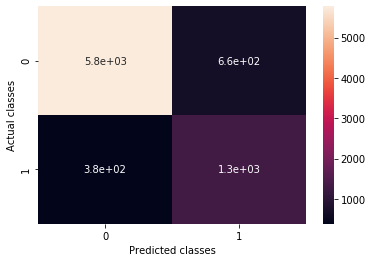

In [323]:
cfm = confusion_matrix(y_predict, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

Сохраним модель

In [328]:
filename = 'final_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

### 5. SHAP

In [309]:
x_data = pd.get_dummies(df_copy.drop('income', axis=1))
y_data = df_copy['income']

#разделим данные на train/test
x_train, x_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [310]:
%%time

model = xgb.train({"learning_rate": 0.01},
                  xgb.DMatrix(x_train, label=Y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

Wall time: 15.8 s


#### 5.1. Построение важности признаков для всего тестового набора данных (summary_plot - дать интерпретацию)

In [311]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

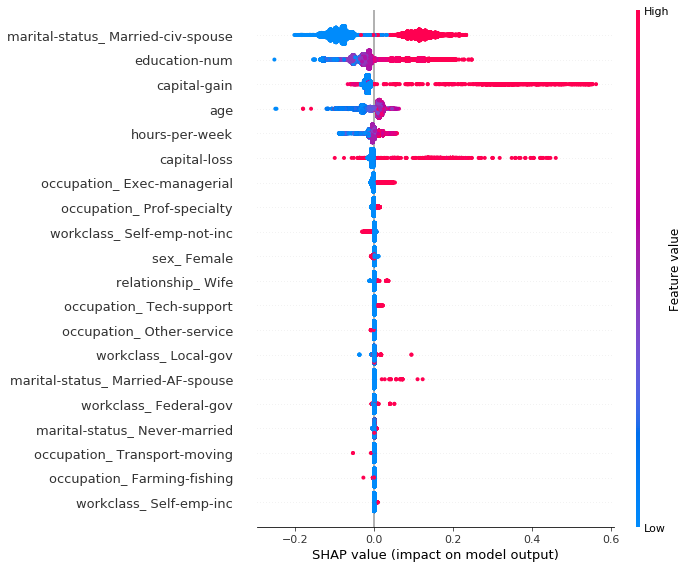

In [312]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train)

Интерпретация summary_plot: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать следующие выводы:
- наличие образования увеличивает вероятность получения дохода свыше 50К
- статус семейного партнера является преобладающим при доходе свыше 50К
- возраст влияет на уровень дохода

#### 5.2. Построение важности признаков для топ 10%

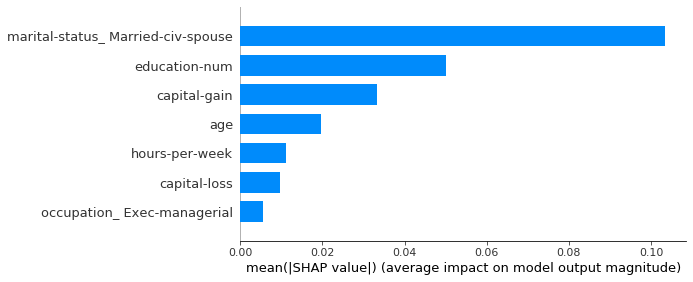

In [317]:
shap.summary_plot(shap_values=shap_values, features=x_train, plot_type='bar', max_display=7)

### 6. Вывод force_plot для отдельных наблюдений, интерпретация результата

In [318]:
def force_plot(sample_number):
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], x_train.iloc[sample_number, :]))

In [319]:
force_plot(sample_number=1200)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1200,45,Federal-gov,320818,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,80,United-States,>50K


In [320]:
force_plot(sample_number=2000)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
2000,35,Private,82552,HS-grad,9,Never-married,Craft-repair,Unmarried,White,Male,0,0,35,United-States,<=50K


In [321]:
force_plot(sample_number=2400)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
2400,32,State-gov,117927,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K


Объект 1200:
* доход свыше 50К
* образование HS-grad
* находится в семейном партнерстве
* возраст 45 лет

Объект 2000:
* доход до 50К
* образование HS-grad
* не состоял в семейном партнерстве
* возраст 35 лет

Объект 2400:
* доход до 50К
* образование Some-college
* не состоял в семейном партнерстве
* возраст 32 года

По уровню образования все объекты примерно равны. Объект 1200 находится в семейном партнерстве, а также старше объектов 2000 и 2400, но младше 49 лет, что увеличивает вероятность дохода свыше 50К. По факту объект 1200 имеет доход свыще 50К, а два других объекта - не имеют.